## Mercari Price Suggestion Algorithm

Mercari, Japan’s biggest community-powered shopping app, wants to develop an algorithm to suggest right product prices to sellers.

Approach:
- Data provided consists of 1.5 million products and each product has attributes: Name, category, description etc.
- The biggest challenge with the data was the product name and description are not of a standard format and the seller can write these fields in their own words.
- To use the seller given product name and description for price prediction, these fields are converted into vectors using word2vec model and the sequences are then run through a recurrent neural network.
- The RNN model is then combined with remaining available attributes and newly engineered attributes to develop a deep learning model for accurate price predictions.


[Import packages and data](#import)<br/>
[Data Cleaning](#cleaning)<br/>
[Feature Engineering](#eng)<br/>

The 'Feature Engineering' code takes 1 - 1.5 hour to run. You can skip running the code for 'Data Cleaning'/'Feature Engineering' and directly import the modified data here <br/>
[Import cleaned data with new features from 'Feature Engineering' section](#import2)<br/>

[Exploratory Data Analysis](#eda)<br/>
[Data Preprocessing for RNN model](#pre)<br/>
[RNN model](#rnn)<br/>

<a id='import'></a>
## Import required packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow.python.framework import ops

from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten, Activation,  BatchNormalization, InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras import backend as K
np.random.seed(1) #set the random seed for consistency

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/mercari_data.tsv', sep = '\t')
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


<a id='cleaning'></a>
## Data Cleaning

In [4]:
data['category_name'].fillna("missing", inplace = True)
data['brand_name'].fillna("missing", inplace = True)
data['item_description'].fillna("missing", inplace = True)
data['item_description'].replace('No description yet', 'missing', inplace = True)


<a id='eng'></a>
## Feature Engineering

#### Attribute: category_name
'category_name' is string of sub-category-1/sub-category-2/sub-category-3. This can be divided into 3 new attributes that helps model understand product's category better.

In [5]:
data['category_name']= data['category_name'].astype(str)
cat_df = pd.DataFrame(data['category_name'].str.split('/',2).tolist(), columns = ['cat1','cat2','cat3'])
data = pd.concat([data, cat_df], axis=1)
data.cat2.fillna('missing', inplace=True)
data.cat3.fillna('missing', inplace=True)

In [6]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat1,cat2,cat3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,missing,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


#### Attribute: brand_name
42% of the values are missing. Looking at data where brand_name is missing, we can see some records hav the brand_name as part of 'name'/'item_description'. To identify brand names from these attributes we will compare the text content with a list of all brands sold on mercari.

We will use the full brand list from 'https://www.mercari.com/brand/'. This data is formatted into a csv and is available in the data folder as 'Mercari_Brand_List.csv'

In [7]:
brand_list = pd.read_csv('Mercari_Brands_List.csv', encoding='latin-1')

In [8]:
all_brands = brand_list['Brand Name'].values

In [9]:
premissing = len(data.loc[data['brand_name'] == 'missing'])
print('brand_name missing count:', premissing)
def brandfinder(line):
    brand = line[0]
    name = line[1]
    namesplit = name.split(' ')
    if brand == 'missing':
        for x in namesplit:
            if x in all_brands:
                return x
    if name in all_brands:
        return name
    return brand
data['brand_name_new'] = data[['brand_name','name']].apply(brandfinder, axis = 1)
found = premissing-len(data.loc[data['brand_name_new'] == 'missing'])
print("brand_name found in name:" ,found)

premissing = len(data.loc[data['brand_name_new'] == 'missing'])
data['brand_name_new2'] = data[['brand_name_new','item_description']].apply(brandfinder, axis = 1)
found = premissing-len(data.loc[data['brand_name_new2'] == 'missing'])
print('brand_name found in item_description:', found)

brand_name missing count: 632682
brand_name found in name: 154215
brand_name found in item_description: 97171


#### Attribute: word count of name and item_description

In [10]:
def token_count(text):
    try:
        if text == 'missing':
            return 0
        else:
            text = text.lower()
            tokens = [t for t in text.split(" ")]
            return len(tokens)
    except: 
        return 0
data['desc_len'] = data['item_description'].apply(lambda x: token_count(x))
data['name_len'] = data['name'].apply(lambda x: token_count(x))

<a id='import2'></a>
The below data import code is optional. The 'mercari_brand_upd.csv' file has all the changes coded in 'Data Cleaning' and 'Feature Engineering' sections. The brandfinder code takes 1 - 1.5 hour to run, you can skip this step and import the modified data here.

In [4]:
data = pd.read_csv('data/mercari_data_upd.csv')

brand_name_new is populated by looking for mercari brands in the name column. Similarly, brand_name_new2 is populated by looking for mercari brands in the item_description column.

Matching words in 'item_description' to all_brands results multiple false positives. For example, words like Silver, All, Complete are being assigned to brand. So, we will drop 'brand_name_new2' and consider 'brand_name_new' for model training.

Using this technique to get brand_name from name column reduces the number of missing records for brand_name by 111,000

In [14]:
data = data.drop(['brand_name_new2','brand_name'],1)
data = data.rename(columns = {'brand_name_new':'brand_name'})

In [15]:
data.head()

,Unnamed: 0,train_id,name,item_condition_id,category_name,price,shipping,item_description,cat1,cat2,cat3,brand_name,desc_len,name_len
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,10.0,1,missing,Men,Tops,T-shirts,MLB,0,7
1,1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,Razer,36,4
2,2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,Target,29,2
3,3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,missing,32,3
4,4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,missing,5,4


<a id='eda'></a>
## Exploratory Data Analysis

#### TARGET VARIABLE: PRICE

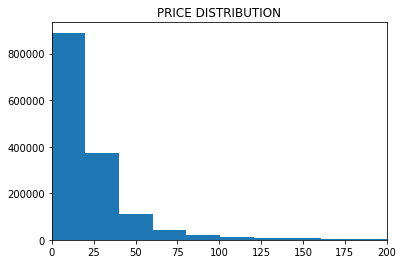

In [16]:
plt.hist(data['price'], bins=100)
plt.xlim(0,200)
plt.title('PRICE DISTRIBUTION')
plt.show()

The target variable is skewed and is not ideal for model training. To tranform this to a normal distribution, we will apply 'numpy.log1p'

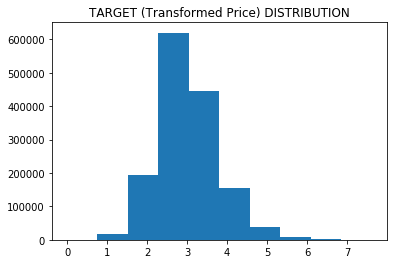

In [17]:
data['target'] = np.log1p(data['price'])

plt.hist(data['target'], bins=10)
plt.title('TARGET (Transformed Price) DISTRIBUTION')
plt.show()

### Price Distribution across categorical attributes

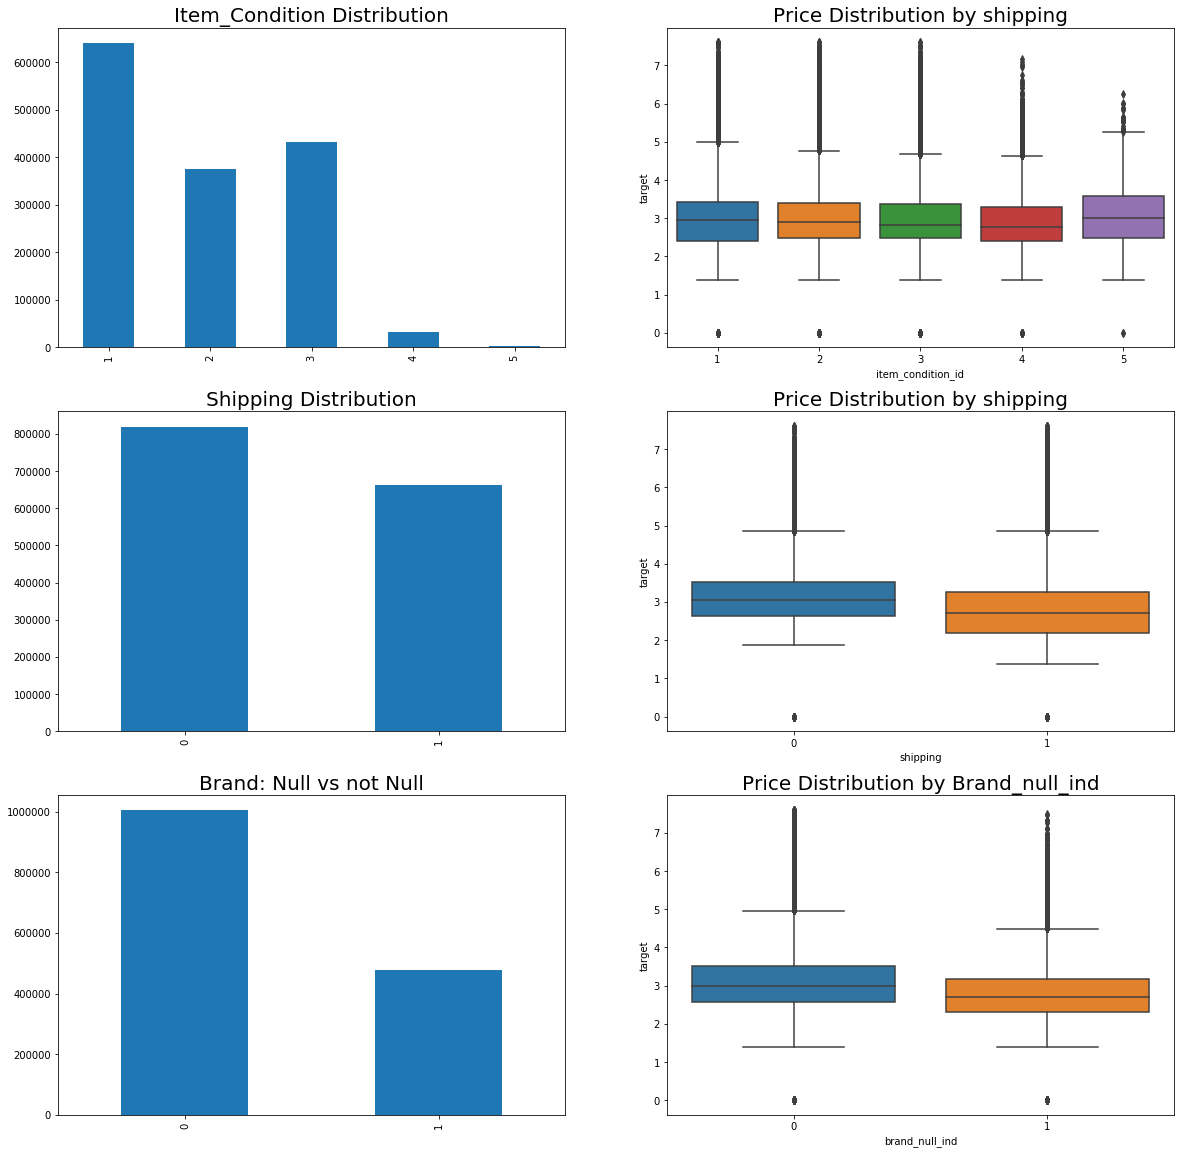

In [18]:
%matplotlib inline
plt.figure(figsize=(20,20));
data['item_condition_id'].value_counts().sort_index().plot(kind='bar', ax=plt.subplot(321));
plt.title('Item_Condition Distribution', fontsize=20);

sns.boxplot(x=data["item_condition_id"], y=data["target"], ax=plt.subplot(322));
plt.title('Price Distribution by shipping', fontsize=20);



data['shipping'].value_counts().sort_index().plot(kind='bar', ax=plt.subplot(323));
plt.title('Shipping Distribution', fontsize=20);
sns.boxplot(x=data["shipping"], y=data["target"], ax=plt.subplot(324));
plt.title('Price Distribution by shipping', fontsize=20);

data['brand_null_ind'] = np.where(data['brand_name']=='missing',1,0)
data['brand_null_ind'].value_counts().sort_index().plot(kind='bar', ax=plt.subplot(325));
plt.title('Brand: Null vs not Null',fontsize=20);
sns.boxplot(x=data["brand_null_ind"], y=data["target"],  ax=plt.subplot(326));
plt.title('Price Distribution by Brand_null_ind',fontsize=20);


The above graphs show that price doesn't vary much based on item_condition_id, but shipping and missing brand indicator seem to have an effect on it.

#### Interaction: Category-1 vs [brand_null_ind, shipping, item_condition]

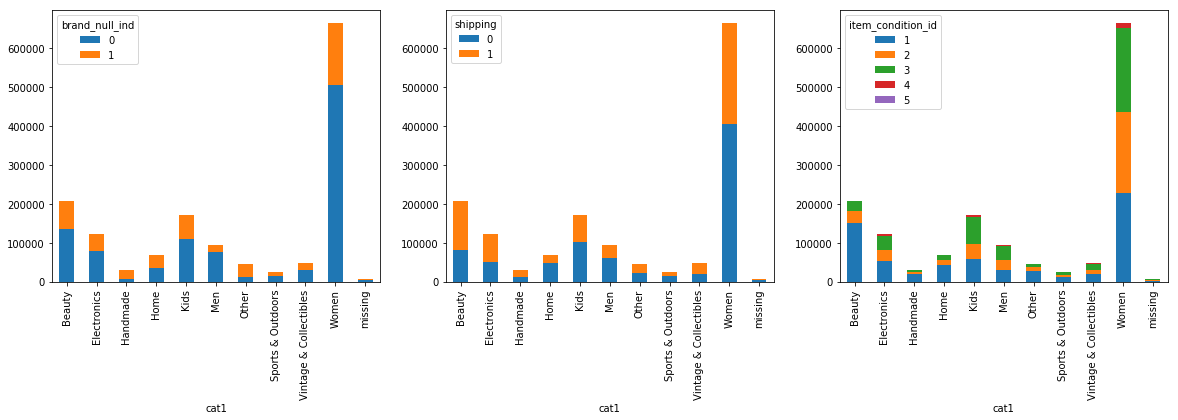

In [19]:

data.groupby(['cat1', 'brand_null_ind'])['cat1'].count().unstack('brand_null_ind')[[0,1]].plot(kind='bar', stacked=True, figsize=(20,5), ax=plt.subplot(131))
data.groupby(['cat1', 'shipping'])['cat1'].count().unstack('shipping')[[0,1]].plot(kind='bar', stacked=True, figsize=(20,5),ax=plt.subplot(132))
data.groupby(['cat1', 'item_condition_id'])['cat1'].count().unstack('item_condition_id')[[1,2,3,4,5]].plot(kind='bar', stacked=True, figsize=(20,5),ax=plt.subplot(133))
plt.show()


item_condition_id, shipping, brand_null_ind seem to distributed equally among all categories.

Lets plot some boxplot of price across category-1, category-2, category-3, and brand. This visualization will give us a sense of interaction between price and these attributes of the product.

### Price Distribution across Product-Category/Brand

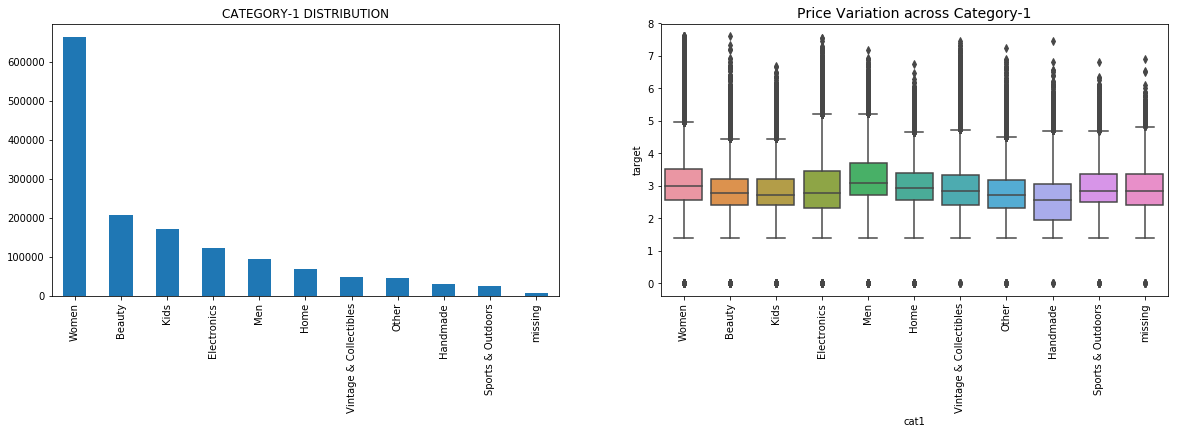

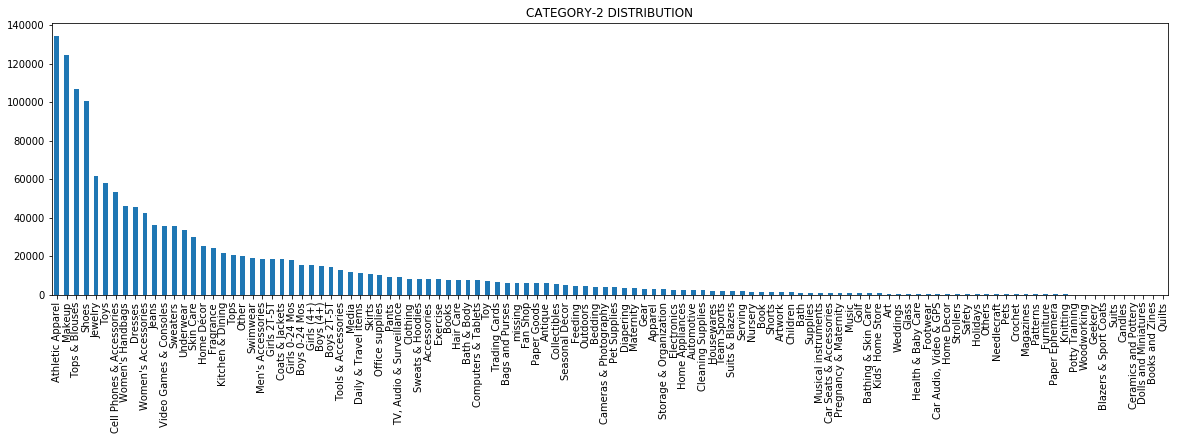

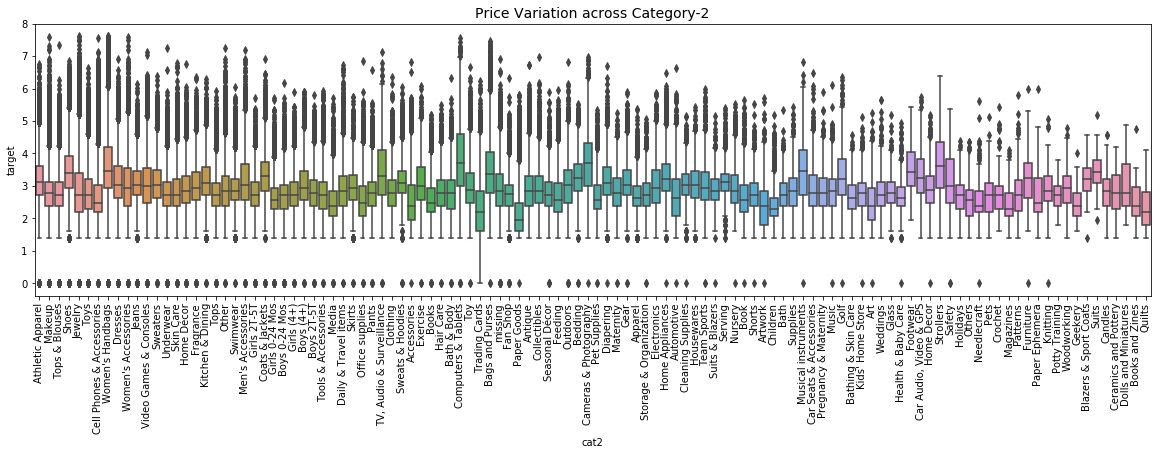

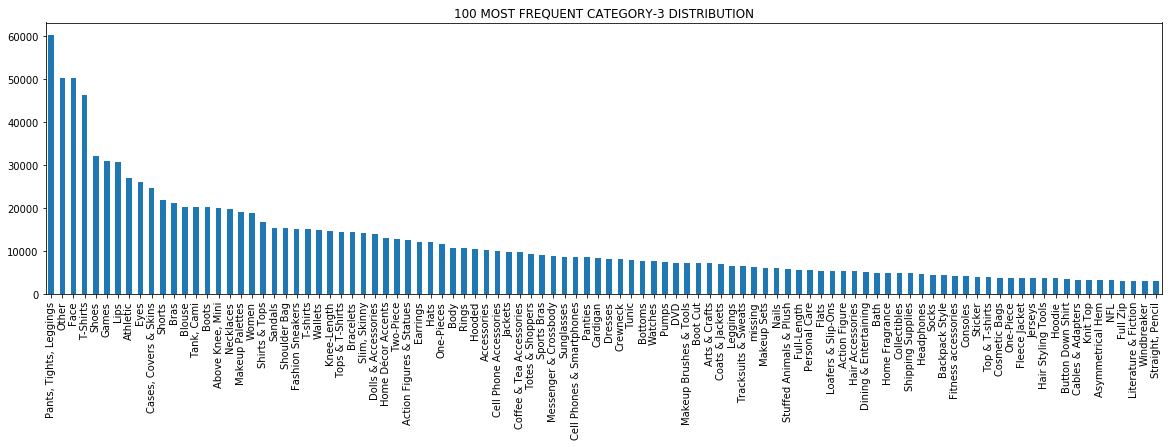

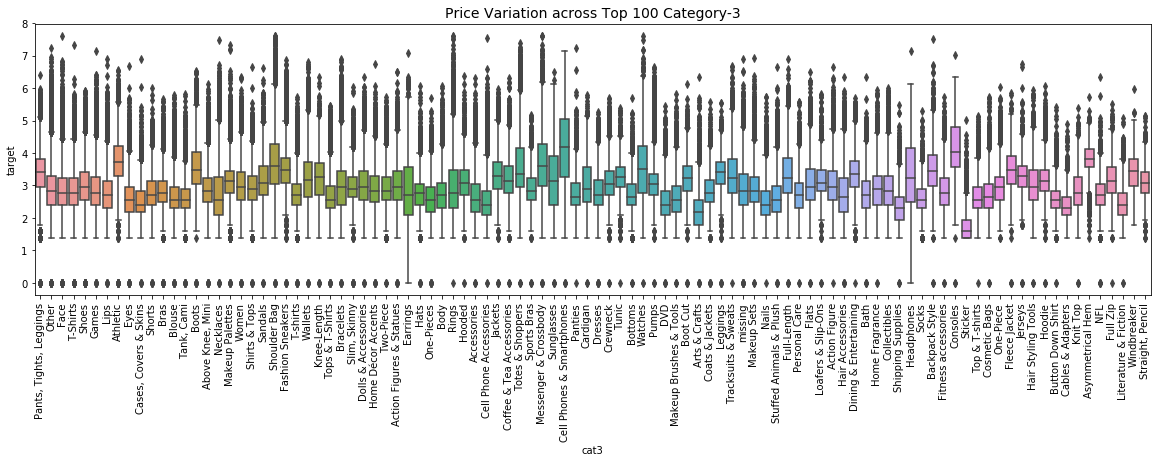

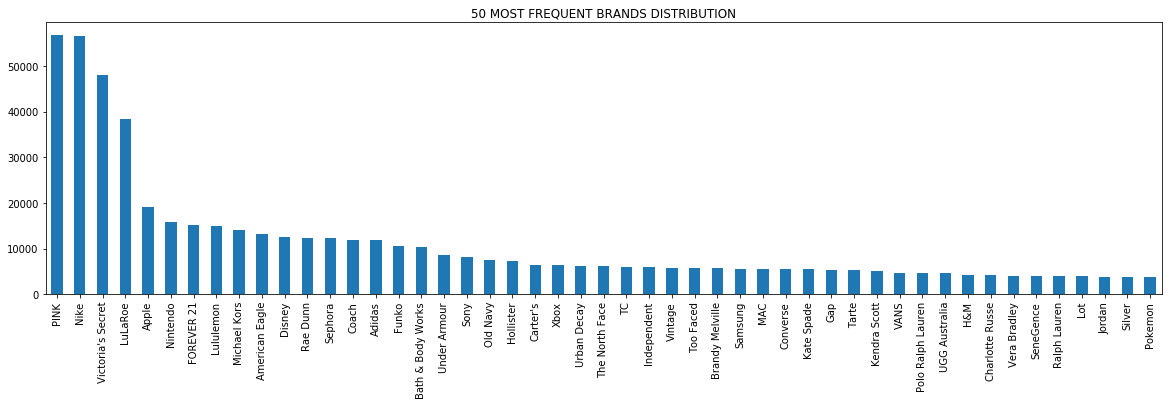

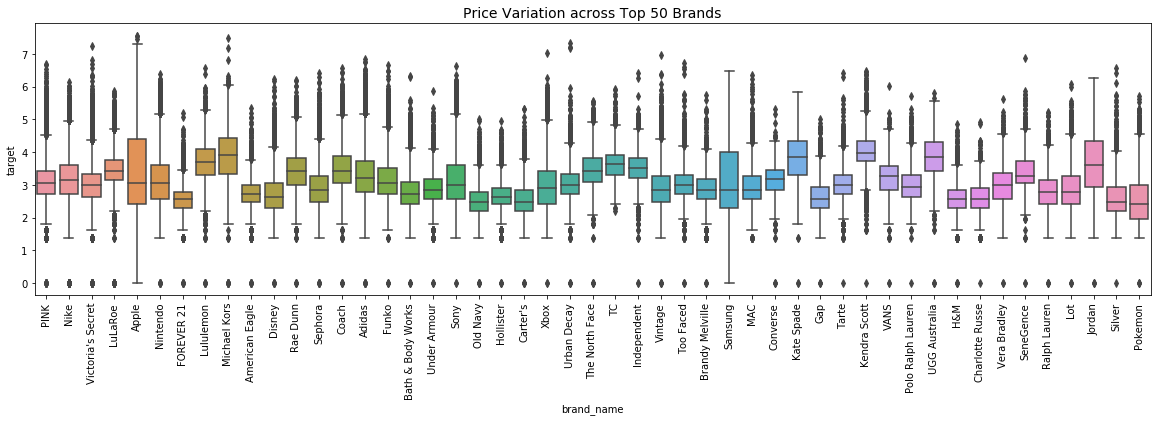

In [20]:
plt.figure(figsize=(20,5))
data['cat1'].value_counts().plot(kind='bar', ax=plt.subplot(121))
plt.title('CATEGORY-1 DISTRIBUTION')
# plt.show()
# plt.figure(figsize=(20,5))
sns.boxplot(x=data["cat1"], y=data["target"],ax=plt.subplot(122), order = data['cat1'].value_counts().index);
plt.title('Price Variation across Category-1', fontsize=14)
plt.xticks(rotation=90)

plt.figure(figsize=(20,5))
data['cat2'].value_counts().plot(kind='bar')
plt.title('CATEGORY-2 DISTRIBUTION')
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=data["cat2"], y=data["target"], order = data['cat2'].value_counts().index);
plt.title('Price Variation across Category-2', fontsize=14)
plt.xticks(rotation=90);


top_cat3 = list(data['cat3'].value_counts()[0:100].index)
top_cat3_data = data.loc[data['cat3'].isin(top_cat3)]

plt.figure(figsize=(20,5))
top_cat3_data['cat3'].value_counts().plot(kind='bar')
plt.title('100 MOST FREQUENT CATEGORY-3 DISTRIBUTION')
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=top_cat3_data['cat3'],y=top_cat3_data['target'], order =top_cat3_data['cat3'].value_counts().index );
plt.title('Price Variation across Top 100 Category-3', fontsize=14)
plt.xticks(rotation=90);

top_50_brands = list(data['brand_name'].value_counts()[1:50].index)

top_50brands_data = data.loc[data['brand_name'].isin(top_50_brands)]
plt.figure(figsize=(20,5))
top_50brands_data['brand_name'].value_counts().plot(kind='bar')
plt.title('50 MOST FREQUENT BRANDS DISTRIBUTION')
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=top_50brands_data['brand_name'],y=top_50brands_data['target'], order = top_50brands_data['brand_name'].value_counts().index);
plt.title('Price Variation across Top 50 Brands', fontsize=14)
plt.xticks(rotation=90);

From the above graphs, it is observed that the IQR (Interquartile range) of price is large for these categories/brands.<br/>
CATEGOGRY-2: Computers & Tablets | Cameras & Photography | TV, Audio, & Surveillance<br/>
CATEGORY-3: Cell Phones & Smartphones | Headphones | Earrings | Sunglasses<br/>
BRAND_NAME: Apple | Samsung<br/>

We can infer that the price varies heavily across electronic products and clothing accessories like (jewelry & watches) as products of these kinds have many of cheap and expensive options in the market.

<a id='pre'></a>
## Data Pre-processing for RNN model

In [21]:

data['brand_name'] = LabelEncoder().fit_transform(data['brand_name'])
data['cat1'] = LabelEncoder().fit_transform(data['cat1'])
data['cat2'] = LabelEncoder().fit_transform(data['cat2'])
data['cat3'] = LabelEncoder().fit_transform(data['cat3'])
data['name_code'] = data['name'].apply(lambda x: one_hot(x, 10000))
data['desc_code'] = data['item_description'].apply(lambda x: one_hot(x, 10000))

In [22]:
data.head()

,Unnamed: 0,train_id,name,item_condition_id,category_name,price,shipping,item_description,cat1,cat2,cat3,brand_name,desc_len,name_len,target,brand_null_ind,name_code,desc_code
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,10.0,1,missing,5,102,762,3091,0,7,2.397895,0,"[970, 2132, 5655, 1771, 121, 1044, 6026]",[8125]
1,1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,52.0,0,This keyboard is in great condition and works ...,1,30,212,4139,36,4,3.970292,0,"[5623, 3895, 9849, 5931]","[8014, 5931, 4351, 2619, 3104, 486, 9999, 502,..."
2,2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,10.0,1,Adorable top with a hint of lace and a key hol...,9,103,94,4882,29,2,2.397895,0,"[8757, 5295, 4145]","[116, 7242, 4098, 6262, 2138, 484, 2522, 9999,..."
3,3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,404,5604,32,3,3.583519,1,"[1123, 9748, 4306]","[1585, 4098, 7103, 1123, 3310, 1804, 1524, 974..."
4,4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,44.0,0,Complete with certificate of authenticity,9,58,536,5604,5,4,3.806662,1,"[9326, 6513, 6764, 4963]","[3938, 4098, 5024, 484, 286]"


In [23]:
train, test = train_test_split(data, random_state=1, train_size=0.95)

/Users/sucharithachintha/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [24]:
def rnn_data(dataset):
    X = {
        'name': pad_sequences(dataset.name_code, maxlen=data.desc_len.max()+1),
        'item_desc': pad_sequences(dataset.desc_code, maxlen=data.name_len.max()+1),
        'brand_name': np.array(dataset.brand_name),
        'item_cond': np.array(dataset.item_condition_id),
        'shipping': np.array(dataset[["shipping"]]),
        'desc_len': np.array(dataset[["desc_len"]]),
        'name_len': np.array(dataset[["name_len"]]),
        'cat1': np.array(dataset.cat1),
        'cat2': np.array(dataset.cat2),
        'cat3': np.array(dataset.cat3),
    }
    return X

In [34]:
X_train = rnn_data(train)
Y_train = train.target.values.reshape(-1,1)
X_test = rnn_data(test)
Y_test = test.target.values.reshape(-1,1)

<a id='rnn'></a>
## RNN Model

In [58]:
## name: Embedding layers converts the onehot representation of words into vector representation
name_input = Input(shape=[X_train["name"].shape[1]], name='name')
name_layer = Embedding(10000, 128)(name_input)
# name_layer = GRU(64, return_sequences=True)(name_layer)
name_layer = GRU(64)(name_layer)
## item_desc
desc_input = Input(shape=[X_train["item_desc"].shape[1]], name='item_desc')
desc_layer = Embedding(10000, 128)(desc_input)
# desc_layer = GRU(64, return_sequences=True)(desc_layer)
desc_layer = GRU(64)(desc_layer)
## brand_name
brand_input = Input(shape=[1], name='brand_name')
brand_layer = Embedding(data.brand_name.max()+1, 64)(brand_input)
brand_layer  = Flatten()(brand_layer)

## cat1
cat1_input = Input(shape=[1], name='cat1')
cat1_layer = Embedding(data.cat1.max()+1, 64)(cat1_input)
cat1_layer = Flatten()(cat1_layer)

## cat2
cat2_input = Input(shape=[1], name='cat2')
cat2_layer = Embedding(data.cat2.max()+1, 64)(cat2_input)
cat2_layer = Flatten()(cat2_layer)

## cat3
cat3_input = Input(shape=[1], name='cat3')
cat3_layer = Embedding(data.cat3.max()+1, 64)(cat3_input)
cat3_layer = Flatten()(cat3_layer)

## item_condition, shipping, desc_len, name_len
item_cond_input = Input(shape=[1], name="item_cond")
shipping_input = Input(shape=[1], name="shipping")
desc_len_input = Input(shape=[1], name="desc_len")
name_len_input = Input(shape=[1], name="name_len")


merged = concatenate([name_layer, desc_layer, brand_layer, cat1_layer, cat2_layer, cat3_layer, 
                      item_cond_input, shipping_input, desc_len_input,name_len_input ])
merged = Dense(256, activation='relu') (merged)
merged = Dropout(0.2)(merged)
merged = Dense(128, activation='relu') (merged)
merged = Dropout(0.2)(merged)
merged = Dense(64, activation='relu') (merged)
merged = Dropout(0.2)(merged)

output = Dense(1, activation="linear") (merged)

model2 = Model([name_input, desc_input, brand_input,cat1_input, cat2_input, cat3_input, item_cond_input,
              shipping_input, desc_len_input, name_len_input], output)

model2.compile(optimizer='Adam', loss='mse')
model2.summary()
model2.fit(X_train, Y_train, epochs=3, batch_size=512,validation_data=(X_test, Y_test), verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               (None, 246)          0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 18)           0                                            
__________________________________________________________________________________________________
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
cat1 (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
cat2 (Inpu

mean square log error = 0.22<br/>
root mean square log error = 0.46